### Zernike Holography

Optical aberration is a pervasive roadblock to good imaging.
Aberration can be modeled as a phase distortion upon an optical wavefront:
while a flat wavefront is free of aberration, non-ideal optical elements impart
a sort of distortion hologram on the beam leading to distorted spots.
Zernike polynomials act as a good (orthonormal under some conditions) basis to describe
optical aberration, with terms corresponding directly to common forms of aberration.

We have already investigated simple wavefront calibration in a previous example.
The action of this calibration is (in part) to measure the phase distortion
and then compensate for the known distortion by subtracting the phase from the phase of desired holograms.
However, a major problem with this technique is that the measured phase is only valid
for the $k$-vector (corresponding to a point on the camera) at which the calibration was measured.
Other $k$-vectors (points across the field of view of the camera) experience a different
optical path through the optical train and thus experience a different aberration.
In systems with strong distortion, this can lead to good sharp wavefront correction only
in the neighborhood surrounding the calibration point
such as seen in `slmsuite` issue [#30](https://github.com/QPG-MIT/slmsuite/issues/30).

This phenomenon is an invarient for additive correction; 
one cannot find a single addative correction mask to correct all $k$-vectors for a given hologram.
The solution is to instead "bake" the correction into the hologram itself.
In the case of spot holograms, instead of thinking of mapping power to points in 2D space,
it is instead more practical to think of mapping power to points in **Zernike aberration space**,
where each spot has a unique Zernike calibration.


#### Initialization

To start, we initialize our system:

In [1]:
# Header. This is hidden from sphinx with the json metadata:
#   {"nbsphinx":"hidden"}

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path (For the case where it isn't installed via pip).
# slmsuite-examples is assumed to be installed in the same directory as slmsuite.
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography.toolbox.phase import blaze, zernike_sum

In [2]:
# **README**                        (This cell is hidden from readthedocs rendering)
# If you're reading this, you might have gotten an error from loading physical
# hardware in the next cell, but that doesn't mean you can't run this notebook!
# This cell loads virtual hardware. You can proceed to the Simple Holography section.
from slmsuite.hardware.slms.simulated import SimulatedSLM
from slmsuite.hardware.cameras.simulated import SimulatedCamera

# Make the SLM and camera.
slm = SimulatedSLM((1600, 1200), pitch_um=(8,8))
slm.set_source_analytic(sim=True)               # Program the virtual source.
slm.set_source_analytic()                       # Don't bother with wavefront calibration, instead just set it to the same source.

cam = SimulatedCamera(slm, (1440, 1100), pitch_um=(4,4), gain=50)

# Tie the camera and SLM together with an analytic Fourier calibration.
fs = FourierSLM(cam, slm)
M, b = fs.fourier_calibration_build(
    f_eff=80000.,                               # f_eff of 80000 wavelengths or 80 mm with the default 1 um wavelength
    theta=5 * np.pi / 180,                      # Slight rotation for fun.
)
fs.fourier_calibrate_analytic(M, b)

In [3]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.5); print()
cam = AlliedVision(serial="02C5V", pitch_um=(3.45, 3.45), fliplr=True)
fs = FourierSLM(cam, slm)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success

vimba initializing... success
Looking for cameras... success
vimba sn '02C5V' initializing... success


smooth:   0%|          | 0/16 [00:00<?, ?it/s]

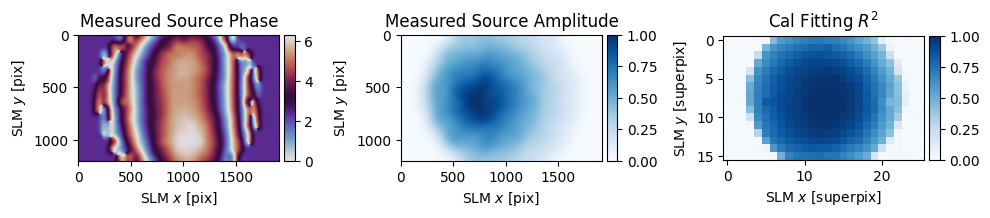

In [4]:
fs.read_calibration("wavefront_superpixel")
fs.wavefront_calibration_superpixel_process(r2_threshold=.5, plot=True);

  0%|          | 0/10 [00:00<?, ?it/s]

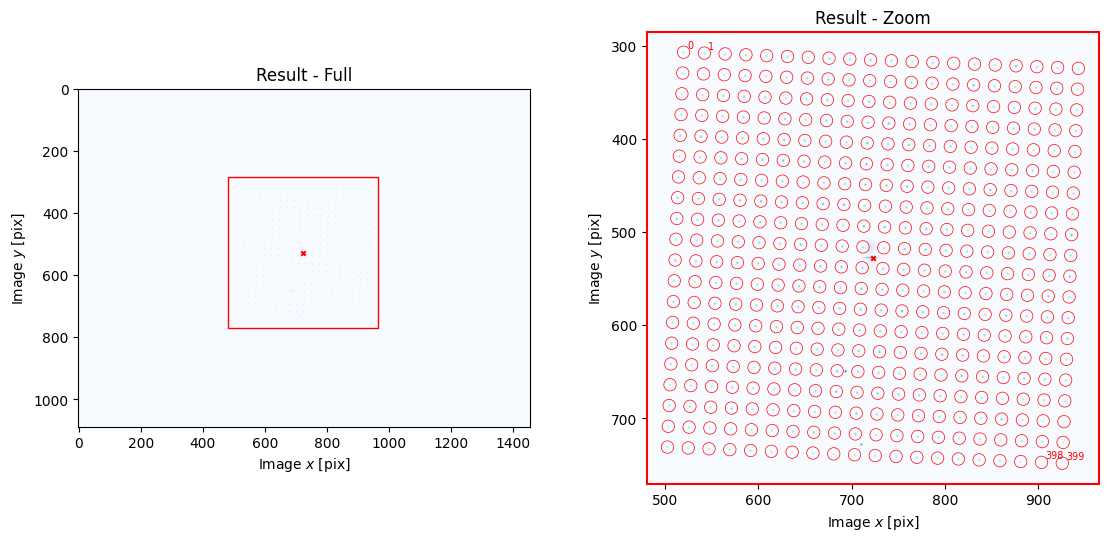

{'M': array([[28857.04043148, -1177.85636476],
        [ 1180.05882475, 28860.25741903]]),
 'b': array([[722.91543747],
        [527.53302081]]),
 'a': array([[-8.76122968e-21],
        [ 5.60718699e-19]]),
 '__version__': '0.1.0',
 '__time__': '2024-07-26 00:56:16.348606',
 '__timestamp__': 1721969776.348606,
 '__meta__': {'camera': '02C5V', 'slm': '2018021001'}}

In [5]:
cam.set_exposure(.002)
fs.fourier_calibrate(20, 20, plot=True)

#### Zernike Indexing

There are many ways to index Zernike polynomials. `slmsuite` supports a number of conventions,
but uses the 1D ANSI `"ansi"` indexing $i$ as the default.
We can find the mapping $Z_i = Z_n^l$ between ANSI and the canonical definition 
`"radial"` consisting of the radial $n$ and azimuthal $l$ orders:

In [6]:
from slmsuite.holography.toolbox.phase import zernike_convert_index

ansi = np.arange(10)
radial = zernike_convert_index(ansi, from_index="ansi", to_index="radial")
print(radial)

[[ 0  0]
 [ 1 -1]
 [ 1  1]
 [ 2 -2]
 [ 2  0]
 [ 2  2]
 [ 3 -3]
 [ 3 -1]
 [ 3  1]
 [ 3  3]]


The nature of the radial $n$ and azimuthal $l$ orders make it often convenient to arange the polynomials in a pyramid:

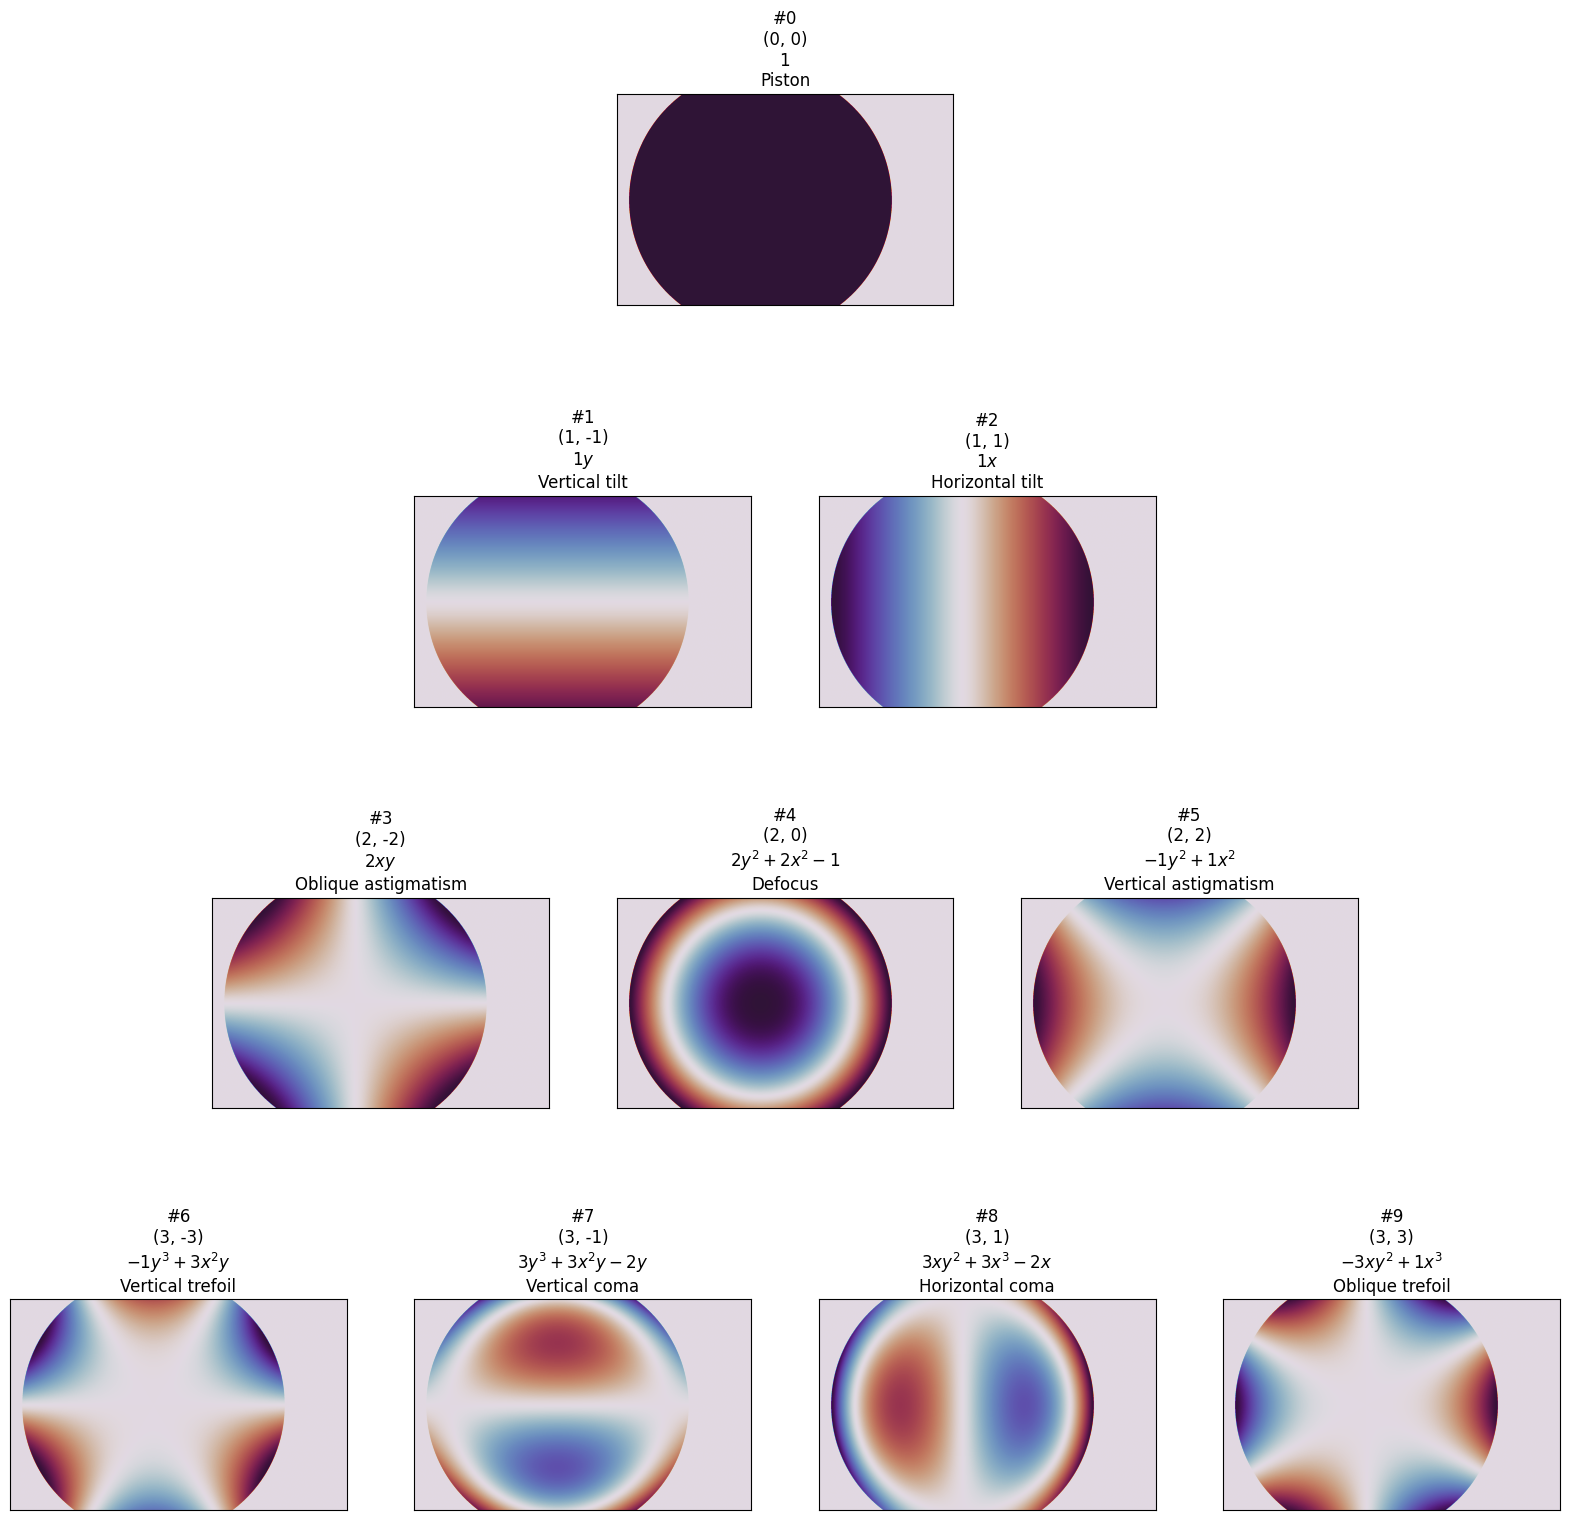

In [7]:
from slmsuite.holography.toolbox.phase import zernike_pyramid_plot

plt.figure(figsize=(20,20))
zernike_pyramid_plot(slm, order=3)

Notice how the polynomials are shifted to correspond with the measured amplitude distribution of the SLM.
This is because `slmsuite` is automatically computing the best center and radius for the polynomials.

`slmsuite` also supports derivates (computed analyticaly via the power rule before rendering, for
speed):

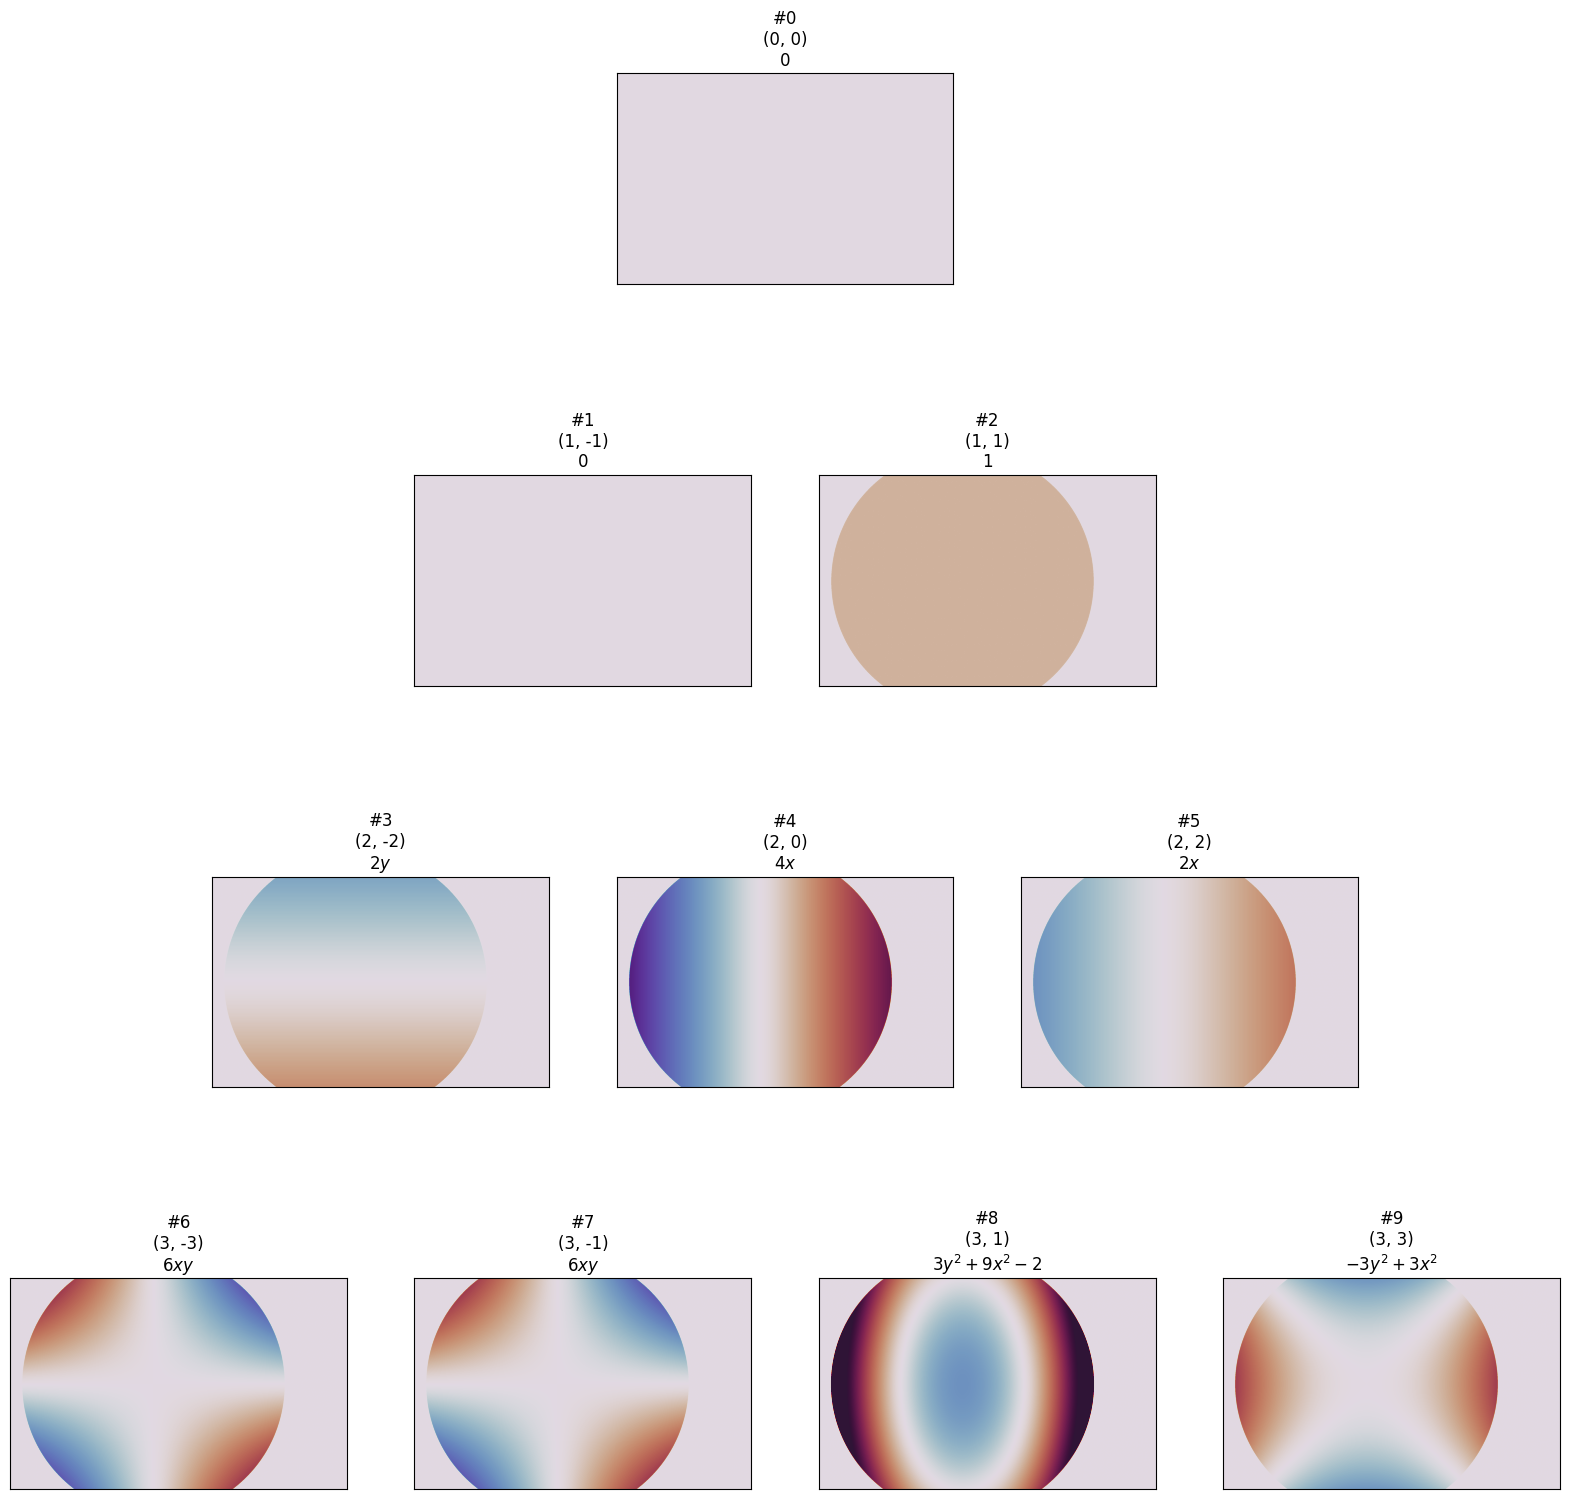

In [8]:
plt.figure(figsize=(20,20))
zernike_pyramid_plot(slm, order=3, derivative=(1, 0), scale=5)    # Adjust the scale because the derivative exceeds [-1, 1]

We can do this for much higher order $n$:

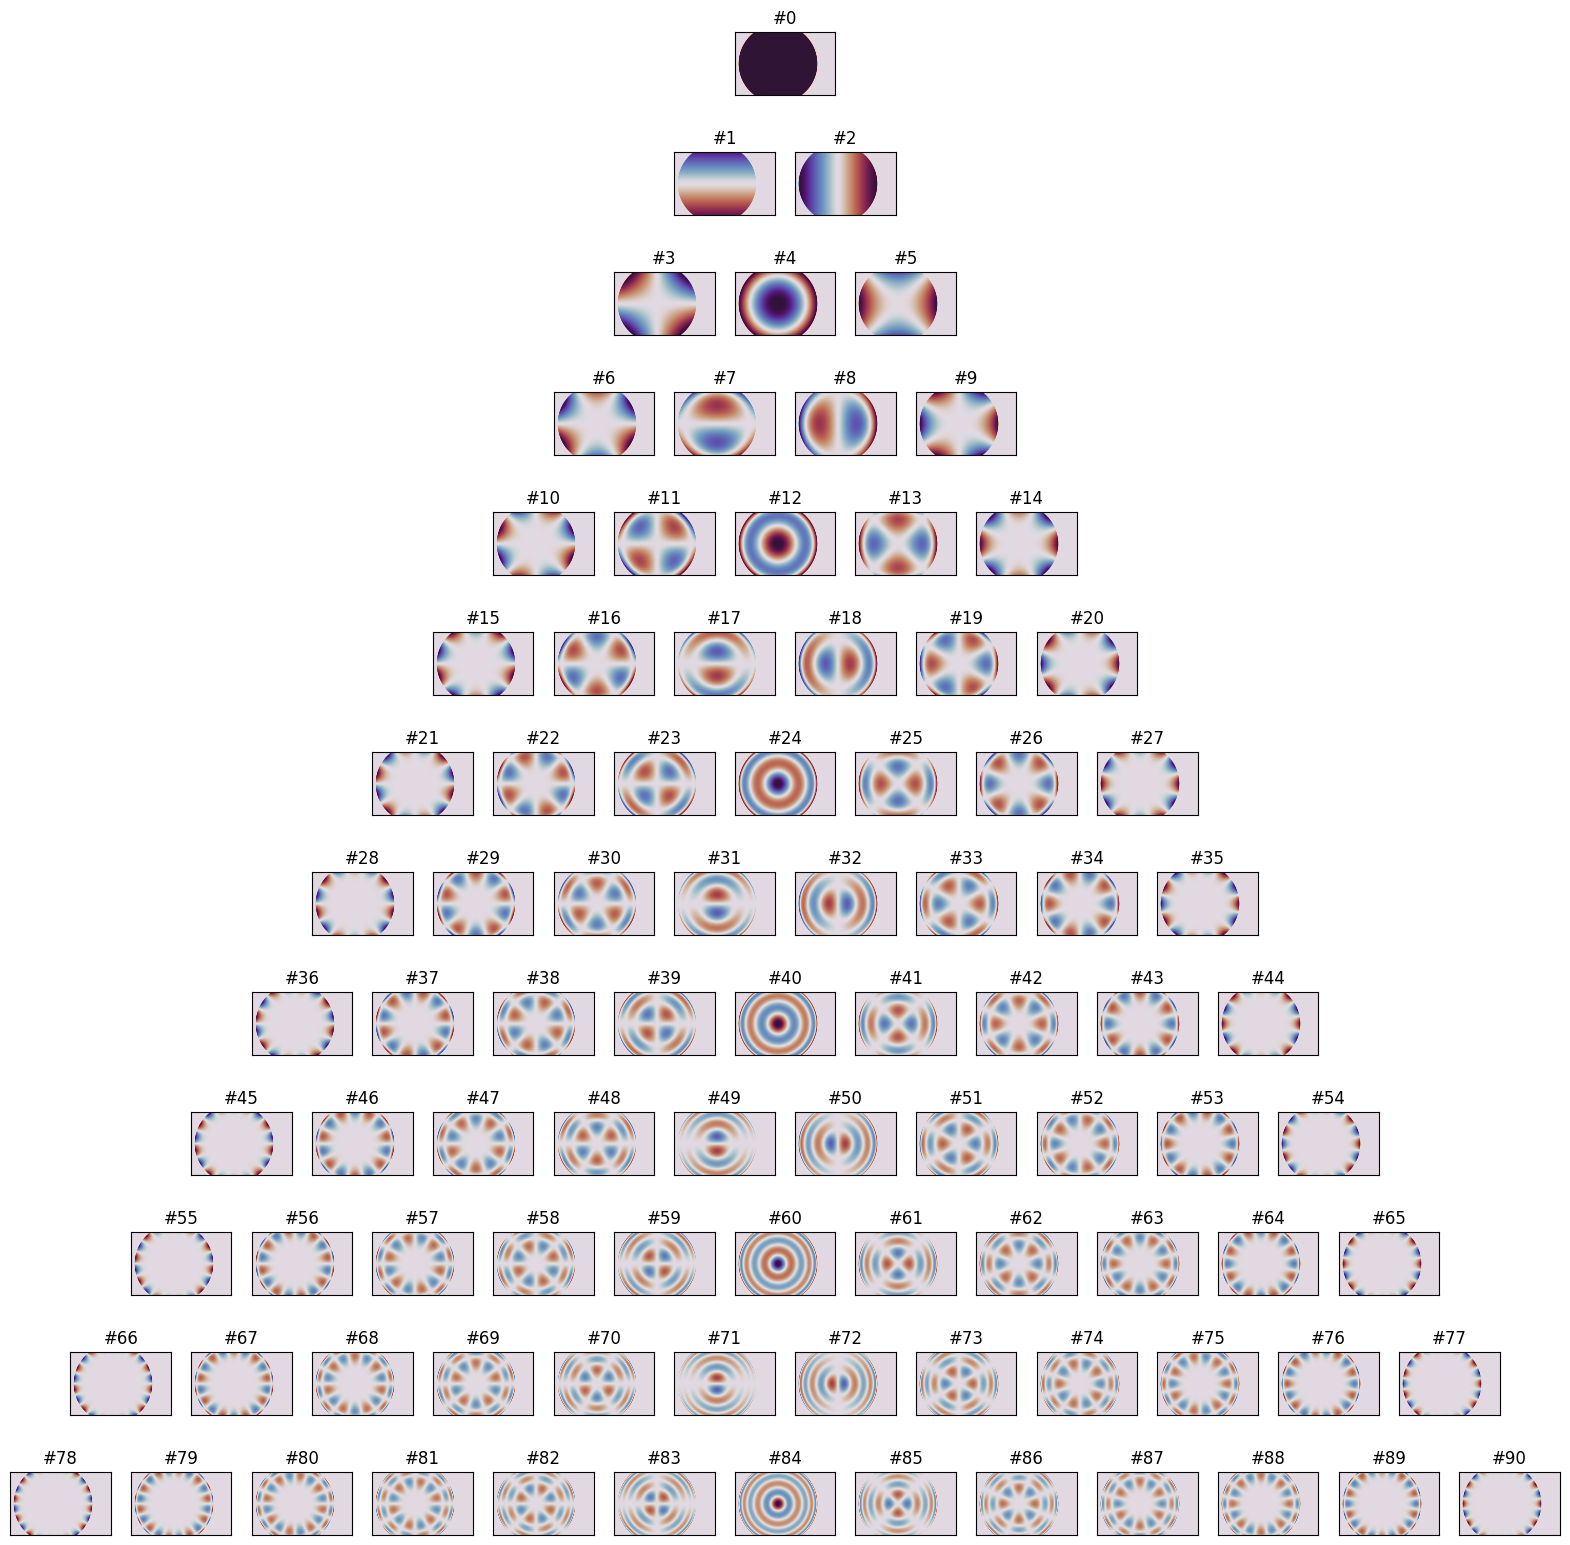

In [9]:
from slmsuite.holography.toolbox.phase import zernike_pyramid_plot

plt.figure(figsize=(20,20))
zernike_pyramid_plot(slm, order=12, titles=["ansi"])

We can grab a single poynomial with `zernike()`:

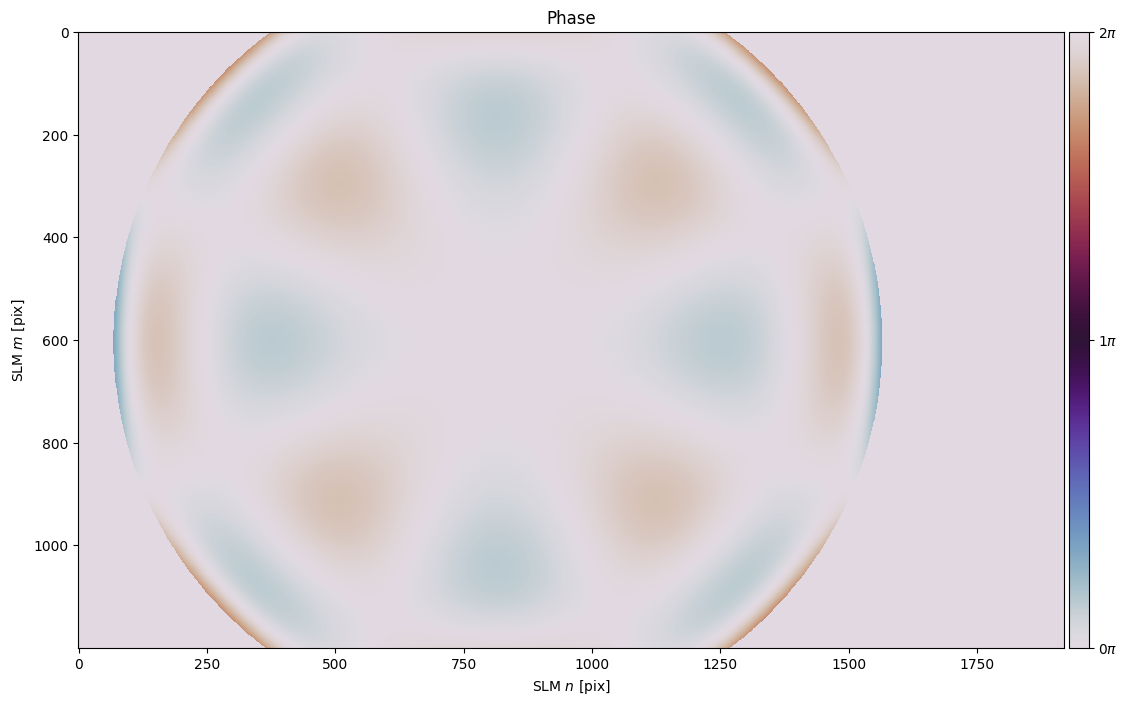

In [10]:
from slmsuite.holography.toolbox.phase import zernike

slm.plot(zernike(slm, 42));

The core function `zernike_sum()` supports generating stacks of sums of Zernike polynomials, with
derivatives are applied to each.

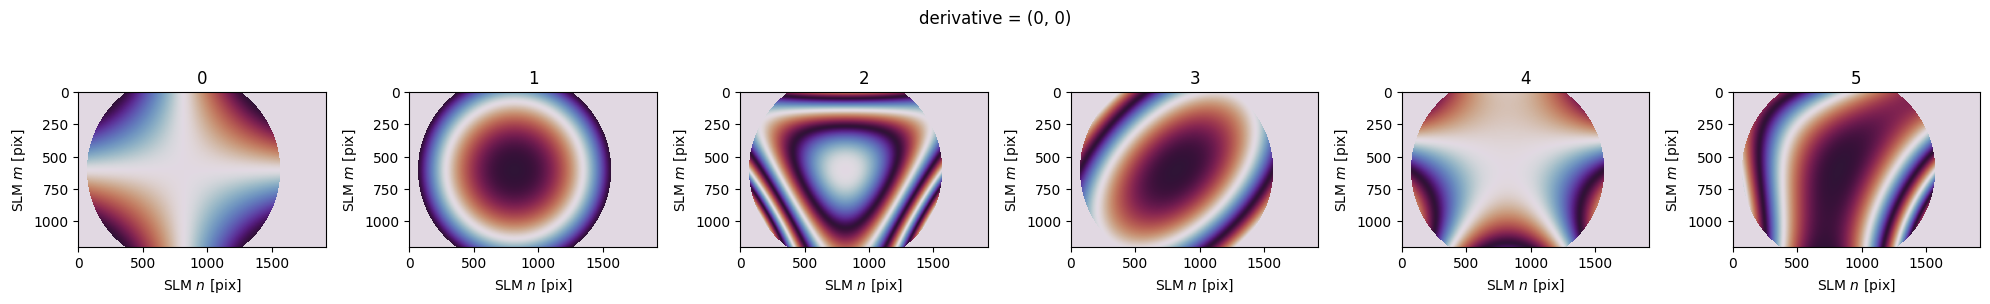

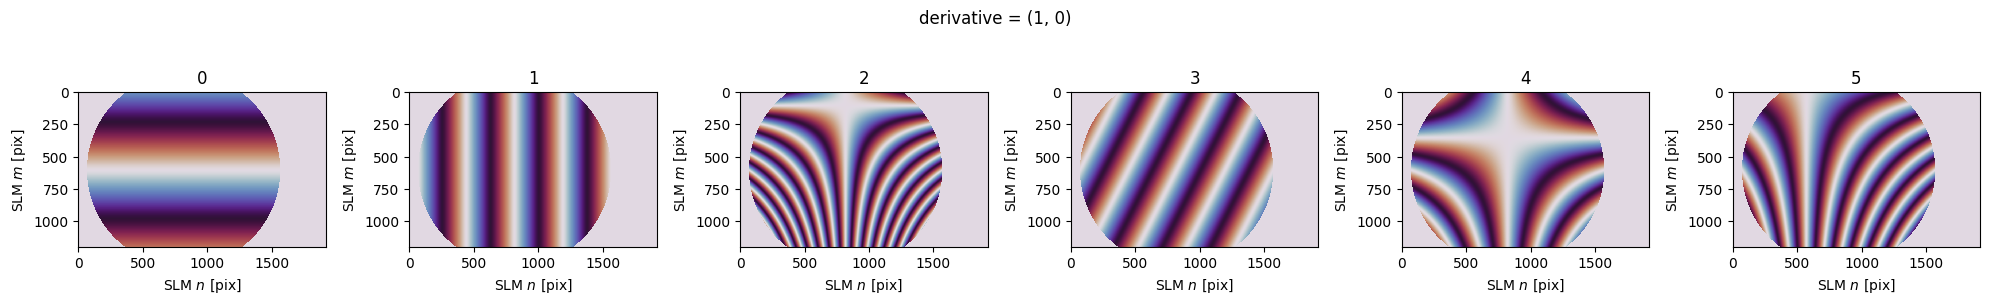

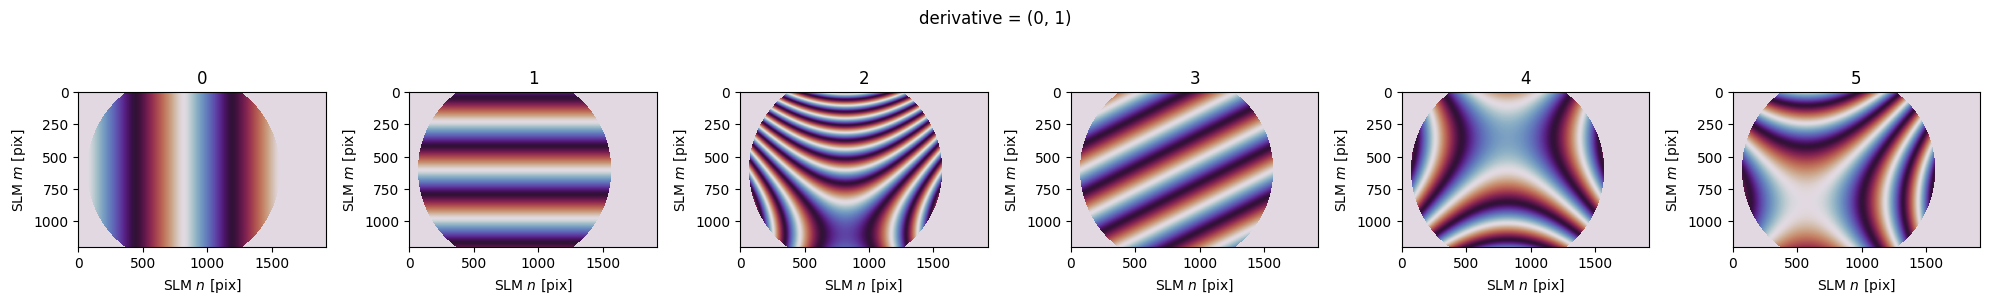

In [11]:
for derivative in [(0,0), (1,0), (0,1)]:
    images = np.pi * zernike_sum(
        slm,
        indices=[3,4,5,6],
        weights=[
            [1,0,0,1,0,1],      # 3
            [0,1,2,1,0,1],      # 4
            [0,0,0,0,1,1],      # 5
            [0,0,2,0,1,1],      # 6
        ],
        derivative=derivative
    )

    fig, axs = plt.subplots(1, 6, figsize=(20,3))

    for i, image in enumerate(images):
        plt.sca(axs[i])
        slm.plot(image, title=str(i), cbar=False)

    plt.suptitle(f"derivative = {derivative}")
    plt.tight_layout()
    plt.show()

#### 3D "Compressed Spot" Holography

A first simple application of the math which "bakes" aberration into a hologram is
with 3D spots. Indeed, the $Z_4 = Z_2^0$ Zernike poynomial is exactly defocus, the 
parabolic term used for translating in $z$.

Let's start by making a desired pointcloud in the camera's pixel `"ij"` coordinates.

In [12]:
from slmsuite.holography.toolbox import convert_vector

N = 100
x = np.arange(N) / 20

zeroth_order_ij = convert_vector((0,0), from_units="norm", to_units="ij", hardware=fs)

vectors_ij = np.vstack((
    50 * (x + 1) * np.cos(2 * np.pi * x) + zeroth_order_ij[0],
    50 * (x + 1) * np.sin(2 * np.pi * x) + zeroth_order_ij[1],
    200 * np.cos(1.5 * np.pi * x)
))

Unit conversions is a major focus of `slmsuite`. The core method `toolbox.convert_vector()`
described previously supports 3D points and converts between the various units.
For most units, "focal power" $1/f$ is used for $z$, but with Fourier calibration and knowledge 
of the camera's pixel pitch in microns, this extends to true cartesion vectors.
If you don't have the `.pitch_um` parameter of the camera set, you will probably see
`nan` for all the $z$ coordinates except for `"ij"`

In [13]:
from slmsuite.holography.toolbox import print_blaze_conversions

print_blaze_conversions(
    vectors_ij[:, 0],       # Print the first vector.
    from_units="ij",
    hardware=fs,
    shape=(2048, 2048)
)

'rad' : [ 1.72979248e-03 -7.07289906e-05  4.39884247e-08]
'mrad' : [ 1.72979248e+00 -7.07289906e-02  4.39884247e-08]
'deg' : [ 9.91098083e-02 -4.05247265e-03  4.39884247e-08]
'norm' : [ 1.72979248e-03 -7.07289906e-05  4.39884247e-08]
'kxy' : [ 1.72979248e-03 -7.07289906e-05  4.39884247e-08]
'knm' : [1.06877239e+03 1.02216931e+03 4.39884247e-08]
'freq' : [ 2.18615163e-02 -8.93889297e-04  4.39884247e-08]
'lpmm' : [ 2.73268954e+00 -1.11736162e-01  4.39884247e-08]
'zernike' : [102.79924314  -4.2033289    6.18145023]
'ij' : [772.91543747 527.53302081 200.        ]
'm' : [0.00266656 0.00181999 0.00069   ]
'cm' : [0.26665583 0.18199889 0.069     ]
'mm' : [2.66655826 1.81998892 0.69      ]
'um' : [2666.55825928 1819.98892179  690.        ]
'nm' : [2666558.25928285 1819988.92178871  690000.        ]
'mag_m' : [0.00266656 0.00181999 0.00069   ]
'mag_cm' : [0.26665583 0.18199889 0.069     ]
'mag_mm' : [2.66655826 1.81998892 0.69      ]
'mag_um' : [2666.55825928 1819.98892179  690.        ]
'mag_n

We can now make the hologram with these 3D points.

In [14]:
from slmsuite.holography.algorithms import CompressedSpotHologram

hologram = CompressedSpotHologram(
    spot_vectors=vectors_ij,
    basis="ij",                 # For 3D spots, the basis defaults to Zernike terms [2,1,4] = [x,y,z].
    cameraslm=fs
)
hologram.optimize()

  0%|          | 0/20 [00:00<?, ?it/s]

In the future, this example will be updated to describe how this process actually works.
In the meantime, let's take a look at what we made:

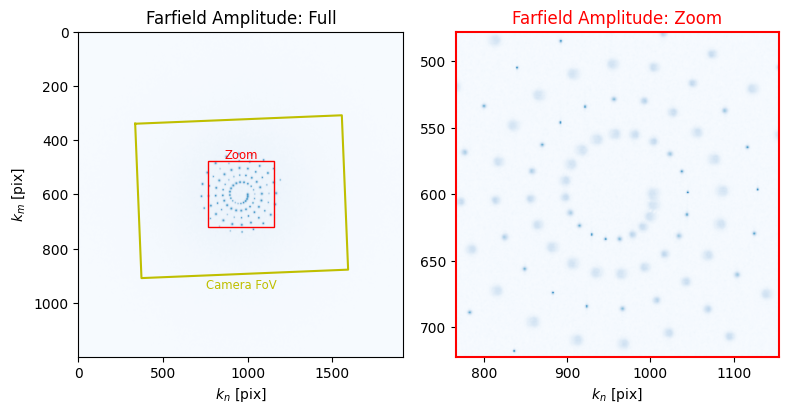

In [15]:
hologram.plot_farfield(limit_padding=-.4);

Under the hood, `slmsuite` is using the above conversions (specifically, going to `"zernike"` space) to figure out what to do.
We can look at this basis of Zernike polynomials (only plotting the first 10/100 for speed). The equivalent Zernike space to $x,y,z$ is $Z_2, Z_1, Z_4$, the tilt and focus terms (see the pyramid).

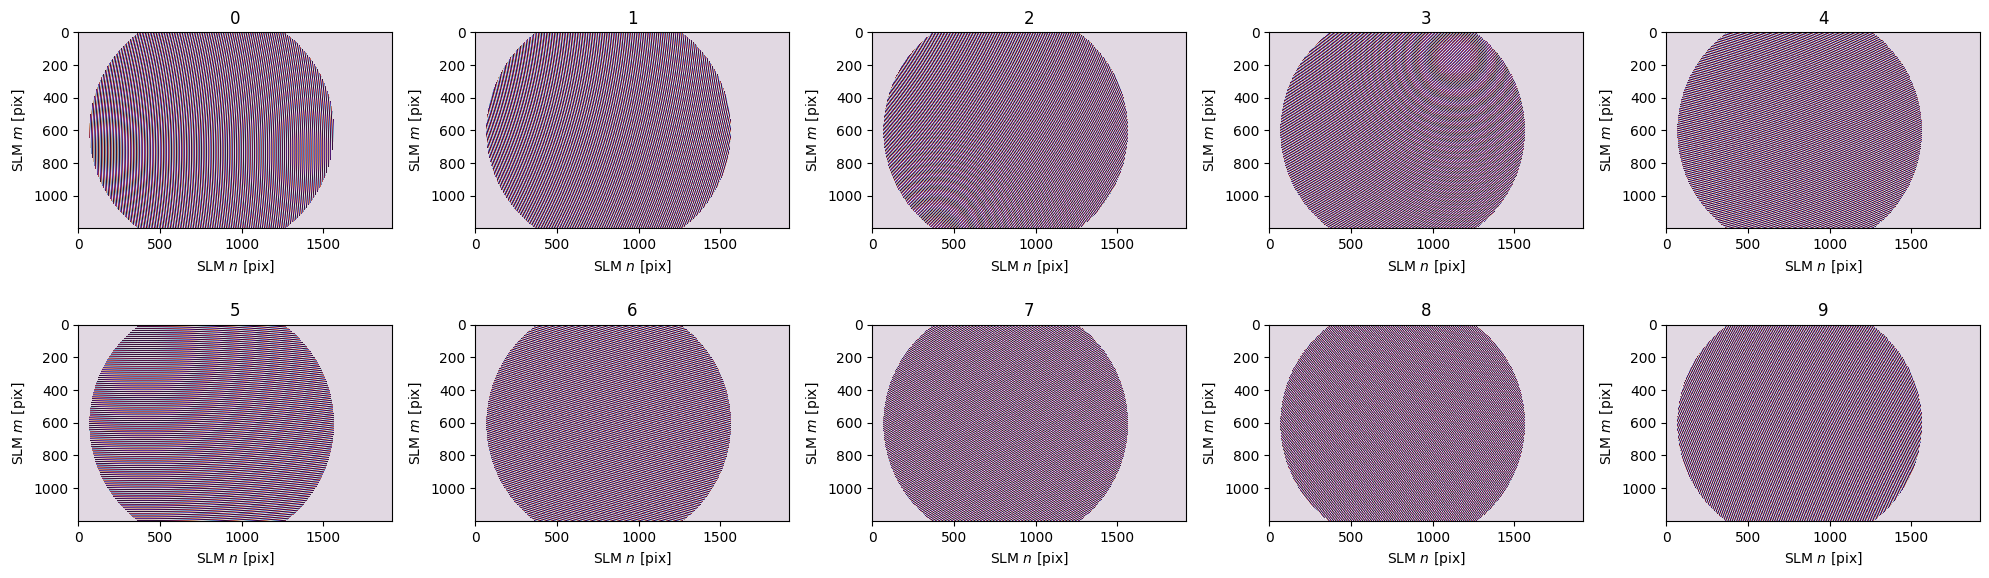

In [16]:
# Get the coordinates in "Zernike space" using the [2,1,4] = [x,y,z] terms.
vectors_zernike = convert_vector(
    vectors_ij,
    from_units="ij",
    to_units="zernike",
    hardware=fs
)

# Plot only the first 10.
images = np.pi * zernike_sum(
    slm,
    indices=None,       # For 3D spots, the basis defaults to Zernike terms [2,1,4].
    weights=vectors_zernike[:, :10]
)

fig, axs = plt.subplots(2, 5, figsize=(20,6))
axs = axs.ravel()

for i, image in enumerate(images):
    plt.sca(axs[i])
    slm.plot(image, title=str(i), cbar=False)

plt.tight_layout()
plt.show()

#### Zernike Spot Holography

As you might imagine, this technique is extensible to far more than the three $Z_2, Z_1, Z_4$ terms.
Let's make a realized Zernike pyramid in a single hologram.

First, let's find the `"zernike"` coordinates of the pyramid corresponding to desired `"ij"` positions.

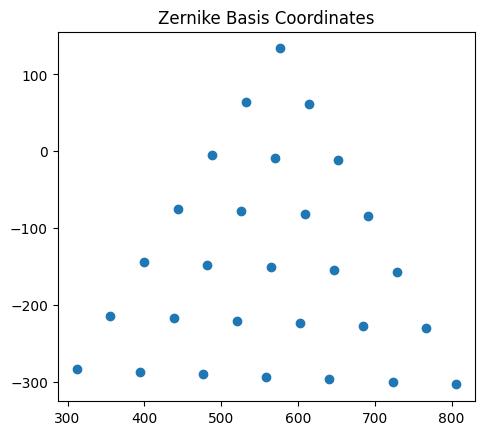

In [17]:
from slmsuite.holography.toolbox import format_vectors

center = format_vectors((1000, 500))
res = (320, 320)
((i0, i1), (i2, i3)) = limits = (
    (int(center[0] - res[0]/2), int(center[0] + res[0]/2)),
    (int(center[1] - res[1]/2), int(center[1] + res[1]/2))
)

N = 28
i = np.arange(N)
nl = zernike_convert_index(i, from_index="ansi", to_index="radial")
ij = 20 * np.vstack((nl[:, 1], (3-nl[:, 0]) * np.sqrt(3))) + center
sz = convert_vector(ij, from_units="ij", to_units="zernike", hardware=fs)

plt.title("Zernike Basis Coordinates")
plt.scatter(sz[0], sz[1])
plt.gca().set_aspect("equal")

base = np.zeros((N,N))

base[2, :] = sz[0]      # Tilt x term
base[1, :] = sz[1]      # Tilt y term

We impart the Zernike term for each spot by adding a perturbation in Zernike-space.

In [18]:
perturbation = np.diag(np.ones(N))
print((base + 10*perturbation)[:10, :10].astype(int))

[[ 10   0   0   0   0   0   0   0   0   0]
 [133  74  60  -5  -8 -12 -74 -78 -81 -84]
 [576 532 624 488 570 652 444 526 608 690]
 [  0   0   0  10   0   0   0   0   0   0]
 [  0   0   0   0  10   0   0   0   0   0]
 [  0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0  10   0   0   0]
 [  0   0   0   0   0   0   0  10   0   0]
 [  0   0   0   0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   0   0   0  10]]


Then, we send these desired coordinates to optimization:

In [24]:
hologram = CompressedSpotHologram(
    spot_vectors=base + 5*perturbation,
    basis=i,
    cameraslm=fs
)

hologram.optimize()

  0%|          | 0/20 [00:00<?, ?it/s]

Let's see what we got:

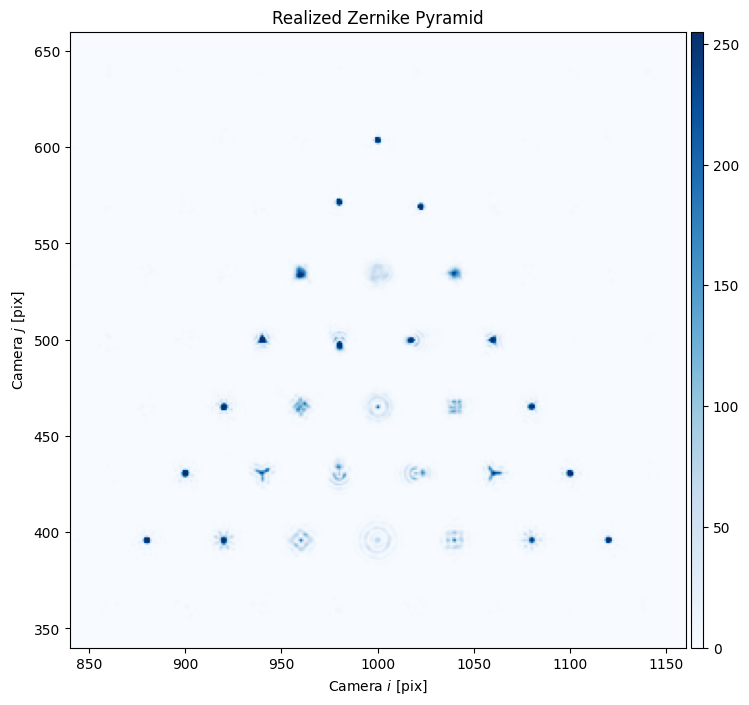

In [27]:
slm.write(hologram.get_phase())
cam.set_exposure(.008)
cam.flush()
cam.plot(limits=limits, title="Realized Zernike Pyramid");

To show how programmable this technique of targeting points in Zernike-space
is, we make a fun .gif:

In [30]:
import tqdm.auto as tqdm

# Make the hologram
hologram = CompressedSpotHologram(
    spot_vectors=base,
    basis=i,
    cameraslm=fs
)
hologram.optimize("WGS-Leonardo", maxiter=50, verbose=False)

# Build the term osillation movie.
imgs = []
X = 5 * np.sin(np.linspace(0, 2*np.pi, 25, endpoint=False))

cam.set_exposure(.004)

for x in tqdm.tqdm(X):
    # Optimize to the new position.
    hologram.spot_zernike = base + x*perturbation
    hologram.optimize("WGS-Leonardo", maxiter=20, verbose=False)

    # Project the pattern.
    slm.write(hologram.get_phase())
    cam.flush()
    imgs.append(cam.get_image()[i3:i2:-1, i0:i1])

  0%|          | 0/25 [00:00<?, ?it/s]

(We use a helper function to render raw data with colormaps, saving the stack of images as a .gif):

In [31]:
from slmsuite.holography.analysis.files import write_image

imgs2 = np.array(imgs, copy=True)
imgs2[imgs2 > 127] = 127
imgs2 *= 2

write_image("ex-zernike-spots.gif", imgs2, cmap="Blues", border=127, normalize=False)
write_image("ex-zernike-spots-dark.gif", imgs, cmap="turbo", border=127, normalize=False)

![light](ex-zernike-spots.gif) 
![dark](ex-zernike-spots-dark.gif)

This feature is be applied to wavefront calibration in the next example, 
to transcend the spatial dependence of aberration across a field of view.